<a href="https://colab.research.google.com/github/fazekas-gergo/composer-ai/blob/master/ComposerAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composer AI
Authors: Fazekas Gergő and Joseph Tadrous<br>
Used dataset: https://www.kaggle.com/soumikrakshit/classical-music-midi

---
## 1. First steps
At first clone the repository, which contains the raw dataset and the created dataframe (which was created in the *Create_DataFrame.ipynb* file).<br>
Then install the required packages and other necessary tools. 


In [1]:
!git clone -l -s https://github.com/fazekas-gergo/composer-ai composer-ai
%cd composer-ai
!pip install midi2audio
!pip install pretty_midi
!sudo apt-get install fluidsynth

Cloning into 'composer-ai'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (429/429), done.
remote: Compressing objects: 100% (422/422), done.
remote: Total 429 (delta 44), reused 346 (delta 4), pack-reused 0
Receiving objects: 100% (429/429), 167.44 MiB | 12.93 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/composer-ai
     |████████████████████████████████| 5.6 MB 4.6 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=0beb6b70ba05d28f9069fa7ee44a40d2e46b3c350d253e2e85917ec426d1585a
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested package

Import required python packages.

In [2]:
import os
import pretty_midi
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import music21
from sklearn.preprocessing import MinMaxScaler

from midi2audio import FluidSynth
from IPython.display import Audio

---
## 2. Data Exploration

The *music21* package lets us to plot the midi file.

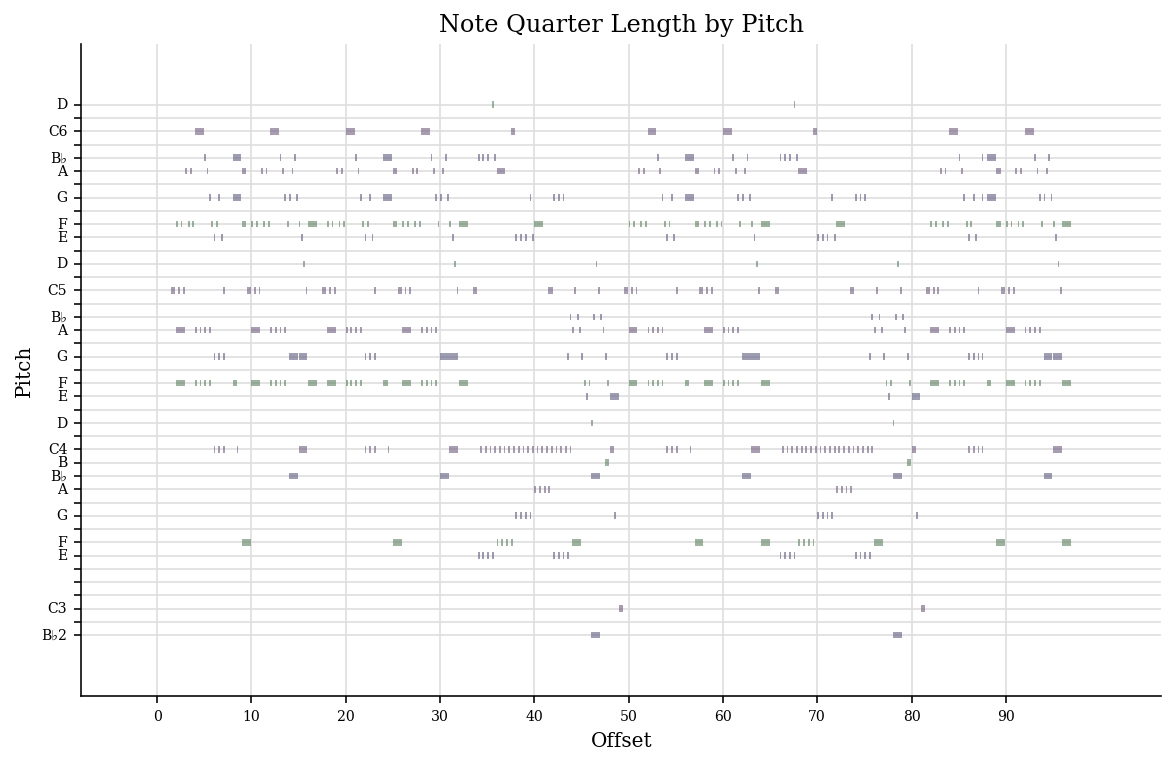

In [ ]:
music = music21.converter.parse('classical_music_midi/haydn/haydn_9_3.mid')
music.plot()

The convert_midi_to_flac function is able to convert the midi file to be listenable by using a soundfont file.

In [22]:
def convert_midi_to_flac(music_path, output='music'):
  FluidSynth('piano.sf2').midi_to_audio(music_path, 'music' + '.flac')
  return 'music' + '.flac'

def play_music(music_path):
  convert_midi_to_flac(music_path, output='music')
  return 'music.flac'

In [ ]:
Audio(play_music('classical_music_midi/haydn/haydn_9_3.mid'))

---
## 3. Load Data Frame

Load dataframe which was already created in the *Create_DataFrame.ipynb* file.<br>

In [29]:
dataset = pd.read_pickle('./dataset.pkl')
dataset

pitches   velocity  \
haydn/haydn_9_3.mid  0                                 [72]  40.000000   
                     1                         [65, 69, 77]  35.666667   
                     2                                 [72]  40.000000   
                     3                                 [77]  41.000000   
                     4                                 [72]  42.000000   
...                                                     ...        ...   
liszt/liz_rhap12.mid 3105  [44, 48, 51, 56, 75, 80, 84, 87]  77.375000   
                     3106  [37, 41, 44, 49, 77, 80, 85, 89]  77.375000   
                     3107  [32, 36, 39, 44, 80, 84, 87, 92]  77.375000   
                     3108  [37, 41, 44, 49, 85, 89, 92, 97]  77.375000   
                     3109  [54, 58, 61, 66, 73, 78, 82, 85]  80.875000   

                           duration  
haydn/haydn_9_3.mid  0     0.251446  
                     1     0.127866  
                     2     0.127866  
                     3     0.127866  
                     4     0.127866  
...                             ...  
liszt/liz_rhap12.mid 3105  0.277136  
                     3106  0.277136  
                     3107  0.277137  
                     3108  1.078652  
                     3109  1.136797  

[357130 rows x 3 columns]

Optionally, we can choose the used pieces at this step.<br>
*For instance we can use only the ones, where the composer is Mozart.*

In [30]:
dataset = dataset.filter(like='mozart/mz_331_3', axis=0)
dataset.index

MultiIndex([('mozart/mz_331_3.mid',    0),
            ('mozart/mz_331_3.mid',    1),
            ('mozart/mz_331_3.mid',    2),
            ('mozart/mz_331_3.mid',    3),
            ('mozart/mz_331_3.mid',    4),
            ('mozart/mz_331_3.mid',    5),
            ('mozart/mz_331_3.mid',    6),
            ('mozart/mz_331_3.mid',    7),
            ('mozart/mz_331_3.mid',    8),
            ('mozart/mz_331_3.mid',    9),
            ...
            ('mozart/mz_331_3.mid', 1550),
            ('mozart/mz_331_3.mid', 1551),
            ('mozart/mz_331_3.mid', 1552),
            ('mozart/mz_331_3.mid', 1553),
            ('mozart/mz_331_3.mid', 1554),
            ('mozart/mz_331_3.mid', 1555),
            ('mozart/mz_331_3.mid', 1556),
            ('mozart/mz_331_3.mid', 1557),
            ('mozart/mz_331_3.mid', 1558),
            ('mozart/mz_331_3.mid', 1559)],
           length=1560)

In [31]:
dataset.describe()

velocity     duration
count  1560.000000  1560.000000
mean     61.205192     0.120950
std      11.939625     0.076061
min      31.000000     0.003311
25%      53.750000     0.099338
50%      61.000000     0.104895
75%      69.000000     0.198675
max      95.333333     0.594059

# 4. Prepare data

Scale duration and velocity columns.

In [32]:
scaler = MinMaxScaler()
scaler.fit(dataset[['duration', 'velocity']])
scaled = scaler.transform(dataset[['duration', 'velocity']])

dataset[['duration', 'velocity']] = scaler.transform(dataset[['duration', 'velocity']])
dataset.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


velocity     duration
count  1560.000000  1560.000000
mean      0.469511     0.199136
std       0.185590     0.128754
min       0.000000     0.000000
25%       0.353627     0.162551
50%       0.466321     0.171958
75%       0.590674     0.330707
max       1.000000     1.000000

Tokenize pitches.

In [33]:
def create_token_from_pitches(pitches):
  note = np.zeros(108-21, dtype=int)
  for pitch in pitches:
    note[pitch - 21] = 1
  return note

dataset['pitches'] = dataset['pitches'].apply(create_token_from_pitches)
dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


pitches  \
mozart/mz_331_3.mid 0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                                     ...   
                    1555  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    1556  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    1557  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    1558  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    1559  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                          velocity  duration  
mozart/mz_331_3.mid 0     0.544041  0.162551  
                    1     0.512953  0.162551  
                    2     0.512953  0.162551  
                    3     0.512953  0.185309  
                    4     0.512953  0.330707  
...                            ...       ...  
                    1555  0.746114  0.053172  
                    1556  0.953368  0.347055  
                    1557  0.772021  0.373373  
                    1558  1.000000  0.769709  
                    1559  0.858031  0.840780  

[1560 rows x 3 columns]

Window dataset

In [34]:
window_size = 64

In [35]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

In [36]:
X_dur_vel, Y_dur_vel = make_timeseries_instances(dataset[['duration', 'velocity']], window_size=window_size)
# Check
assert (X_dur_vel[window_size][0] == Y_dur_vel[0]).all()
X_dur_vel.shape, Y_dur_vel.shape

((1496, 64, 2), (1496, 2))

In [37]:
X_pitches, Y_pitches = make_timeseries_instances(np.array([arr for arr in dataset['pitches'].values]), window_size=window_size)
assert (X_pitches[window_size][0] == Y_pitches[0]).all()
X_pitches.shape, Y_pitches.shape

((1496, 64, 87), (1496, 87))



---
# 5. Create and train model


In [38]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, Reshape, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

## Create model

First create a model for handling input pitches.

In [47]:
pitch_input = Input(shape=(window_size, 108-21), name='pitch_input')

conv = Conv1D(320, kernel_size=3, name='pitch_in_conv_1')(pitch_input)
conv = Conv1D(320, kernel_size=3, name='pitch_in_conv_2')(conv)
conv = Conv1D(320, kernel_size=3, name='pitch_in_conv_3')(conv)
flatten = Flatten()(conv)
dense = Dense(200, activation="relu", kernel_initializer='he_normal', name='pitch_in_dense')(flatten)
dropout = Dropout(0.3)(dense)
output = Dense(200, activation="relu", kernel_initializer='he_normal', name='pitch_in_out')(dropout)
model_pitch_in = Model(inputs=pitch_input, outputs=output, name="model_pitch_in")

model_pitch_in.summary()

Model: "model_pitch_in"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pitch_input (InputLayer)    [(None, 64, 87)]          0         
                                                                 
 pitch_in_conv_1 (Conv1D)    (None, 62, 320)           83840     
                                                                 
 pitch_in_conv_2 (Conv1D)    (None, 60, 320)           307520    
                                                                 
 pitch_in_conv_3 (Conv1D)    (None, 58, 320)           307520    
                                                                 
 flatten_1 (Flatten)         (None, 18560)             0         
                                                                 
 pitch_in_dense (Dense)      (None, 200)               3712200   
                                                                 
 dropout_9 (Dropout)         (None, 200)            

Secondly create another model, which handles the duration and velocity inputs.

In [48]:
dur_vel_input = Input(shape=(window_size, 2), name='dur_vel_input')

# the second branch opreates on the duration and velocity inputs
lstm = LSTM(32, name='dur_vel_in_lstm')(dur_vel_input)
dense = Dense(50, activation="relu", kernel_initializer='he_normal', name='dur_vel_in_dense_1')(lstm)
dropout = Dropout(0.3)(dense)
output = Dense(50, activation="relu", kernel_initializer='he_normal', name='dur_vel_in_out')(dropout)
model_dur_vel_in = Model(inputs=dur_vel_input, outputs=output, name='model_dur_vel_in')

model_dur_vel_in.summary()

Model: "model_dur_vel_in"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dur_vel_input (InputLayer)  [(None, 64, 2)]           0         
                                                                 
 dur_vel_in_lstm (LSTM)      (None, 32)                4480      
                                                                 
 dur_vel_in_dense_1 (Dense)  (None, 50)                1650      
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dur_vel_in_out (Dense)      (None, 50)                2550      
                                                                 
Total params: 8,680
Trainable params: 8,680
Non-trainable params: 0
_________________________________________________________________


Finally, combine these two models and define 2 outputs. One for pitches and one for the duration and velocity values.

In [49]:
# combine the output of the two branches
common_input = concatenate([model_pitch_in.output, model_dur_vel_in.output], name='common_input')

# common branch
common_dense = Dense(300, activation="relu", name='common_dense_1', kernel_initializer='he_normal')(common_input)
dropout = Dropout(0.3)(common_dense)

# outputs
pitch_output = Dense(108-21, activation="sigmoid", name='pitch_output')(dropout)
dur_vel_output = Dense(2, activation='sigmoid', name='dur_vel_output')(dropout)

# define model
model = Model(inputs=[model_pitch_in.input, model_dur_vel_in.input], outputs=[pitch_output, dur_vel_output], name='model')

model.compile(optimizer='adam', 
              loss={'pitch_output': 'binary_crossentropy', 'dur_vel_output': 'mean_squared_error'},
              loss_weights={'pitch_output': 1., 'dur_vel_output': 0.2},
              metrics={'pitch_output': 'acc', 'dur_vel_output': None})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pitch_input (InputLayer)       [(None, 64, 87)]     0           []                               
                                                                                                  
 pitch_in_conv_1 (Conv1D)       (None, 62, 320)      83840       ['pitch_input[0][0]']            
                                                                                                  
 pitch_in_conv_2 (Conv1D)       (None, 60, 320)      307520      ['pitch_in_conv_1[0][0]']        
                                                                                                  
 pitch_in_conv_3 (Conv1D)       (None, 58, 320)      307520      ['pitch_in_conv_2[0][0]']        
                                                                                              

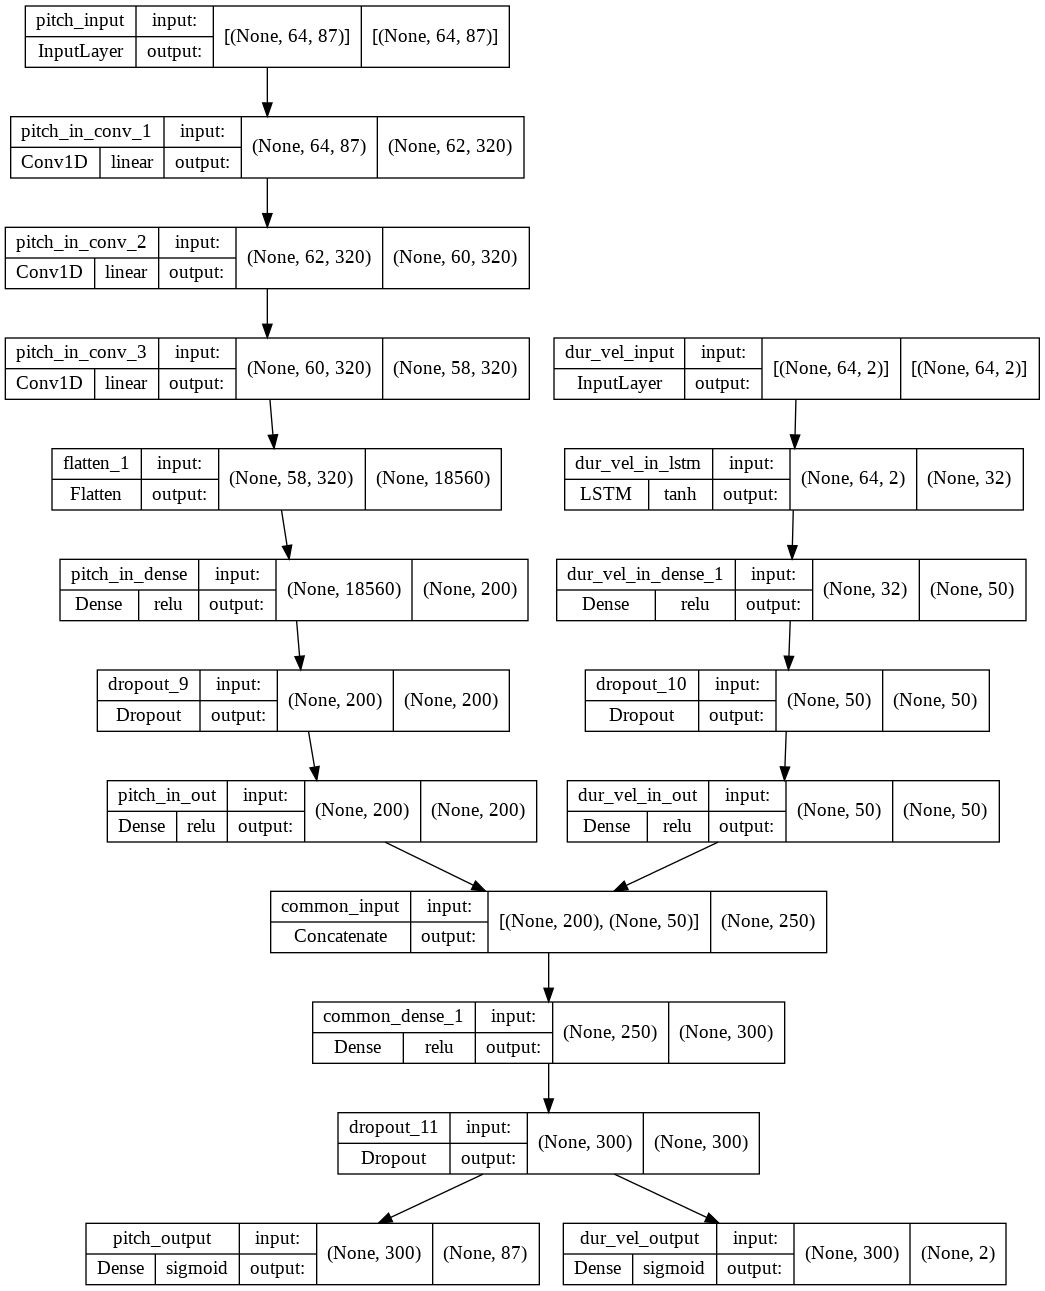

In [50]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

## Train model

In [ ]:
from keras.callbacks import LambdaCallback

def printLog(epoch, logs):
  print('Epoch ', epoch, ':', sep='')
  if 'loss' in logs:
    print('\tloss: {:.4f}'.format(logs['loss']), end='\t\t\t')
    print('val_loss: {:.4f}'.format(logs['val_loss']))
  if 'pitch_output_loss' in logs:
    print('\tpitch loss: {:.4f}, acc: {:.4f}'.format(logs['pitch_output_loss'], logs['pitch_output_acc']), end='\t')
    print('val_loss: {:.4f}, val_acc: {:.4f}'.format(logs['val_pitch_output_loss'], logs['val_pitch_output_acc']))
  if 'pitch_output_loss' in logs:
    print('\tdur_vel loss: {:.4f}'.format(logs['dur_vel_output_loss']), end='\t\t')
    print('val_loss: {:.4f}'.format(logs['val_dur_vel_output_loss']))

printerCallback = LambdaCallback(on_epoch_end=printLog)

In [51]:
es = keras.callbacks.EarlyStopping(patience=500, monitor='val_pitch_output_acc', restore_best_weights=True, verbose=10)
model.fit([X_pitches, X_dur_vel], [Y_pitches, Y_dur_vel], epochs=100000, callbacks=[es], batch_size=2048, validation_split=0.1)

Epoch 1/100000
1/1 [==============================] - 11s 11s/step - loss: 0.7109 - pitch_output_loss: 0.6978 - dur_vel_output_loss: 0.0656 - pitch_output_acc: 0.0022 - val_loss: 0.6604 - val_pitch_output_loss: 0.6447 - val_dur_vel_output_loss: 0.0784 - val_pitch_output_acc: 0.0333
Epoch 2/100000
1/1 [==============================] - 0s 451ms/step - loss: 0.6461 - pitch_output_loss: 0.6374 - dur_vel_output_loss: 0.0434 - pitch_output_acc: 0.0052 - val_loss: 0.4327 - val_pitch_output_loss: 0.4210 - val_dur_vel_output_loss: 0.0586 - val_pitch_output_acc: 0.0333
Epoch 3/100000
1/1 [==============================] - 0s 451ms/step - loss: 0.5370 - pitch_output_loss: 0.5220 - dur_vel_output_loss: 0.0747 - pitch_output_acc: 0.0089 - val_loss: 0.3488 - val_pitch_output_loss: 0.3383 - val_dur_vel_output_loss: 0.0524 - val_pitch_output_acc: 0.0333
Epoch 4/100000
1/1 [==============================] - 0s 453ms/step - loss: 0.4226 - pitch_output_loss: 0.4095 - dur_vel_output_loss: 0.0651 - pitch_

KeyboardInterrupt: ignored

Save model

In [ ]:
from datetime import datetime
import subprocess

# Save model
path = "models/" + str(datetime.now().strftime("%m-%d-%Y_%H-%M-%S"))
model.save(path)

# Zip model to be downloadable
subprocess.call(['zip', '-r', path + ".zip", path])

INFO:tensorflow:Assets written to: models/04-15-2022_20-32-08/assets


INFO:tensorflow:Assets written to: models/04-15-2022_20-32-08/assets


0



---
# 5. Generate music

In [56]:
def generate(num, model, win):
  pitches = np.zeros((num + win, 108-21), dtype=int)
  dur_vel = np.zeros((num + win, 2))
  pitches[:win] = X_pitches[0]
  dur_vel[:win] = X_dur_vel[0]
  for i in range(num):
    x_pitches = np.expand_dims(pitches[i:i+win], axis=0)
    x_dur_vel = np.expand_dims(dur_vel[i:i+win], axis=0)
    pred_pitches, pred_dur_vel = model.predict([x_pitches, x_dur_vel])
    pitches[i+win] = __binarize_pitches(pred_pitches[0])
    dur_vel[i+win] = pred_dur_vel
  dur_vel = scaler.inverse_transform(dur_vel)
  pitches = __get_pitches_from_vectors(pitches)
  return pd.DataFrame({'pitches': pitches, 'duration': dur_vel[:, 0], 'velocity': np.round(dur_vel[:, 1])})

def __binarize_pitches(pred):
  pitches = np.argwhere(pred >= 0.5).reshape(-1)
  if len(pitches) == 0:
    pitches = np.expand_dims(np.argmax(pred), 0)
  elif len(pitches) > 10:
    pitches = np.argsort(pred)[-10:]
  result = np.zeros((108-21), dtype=int)
  for pitch in pitches:
    result[pitch] = 1
  return result

def __get_pitches_from_vectors(vectors):
  result = []
  for vec in vectors:
    result.append(np.argwhere(vec == 1).reshape(-1) + 21)
  return result

generated = generate(512, model, window_size)
generated

pitches  duration  velocity
0            [71]  0.099338      66.0
1            [69]  0.099338      64.0
2            [68]  0.099338      64.0
3            [69]  0.112782      64.0
4        [57, 72]  0.198676      64.0
..            ...       ...       ...
571  [52, 68, 71]  0.446549      61.0
572          [71]  0.098821      58.0
573          [69]  0.108028      56.0
574          [68]  0.096404      56.0
575          [69]  0.120004      56.0

[576 rows x 3 columns]

In [57]:
from pretty_midi import Note

music = pretty_midi.PrettyMIDI()
piano = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

start = 0
for index, note in generated.iterrows():
  for pitch in note['pitches']:
    piano.notes.append(Note(pitch=pitch,
                            velocity=int(note['velocity']), 
                            start=start, 
                            end=start+note['duration']))
  start += note['duration']

# Add the piano instrument to the PrettyMIDI object
music.instruments.append(piano)
# Write out the MIDI data
music.write('output.mid')

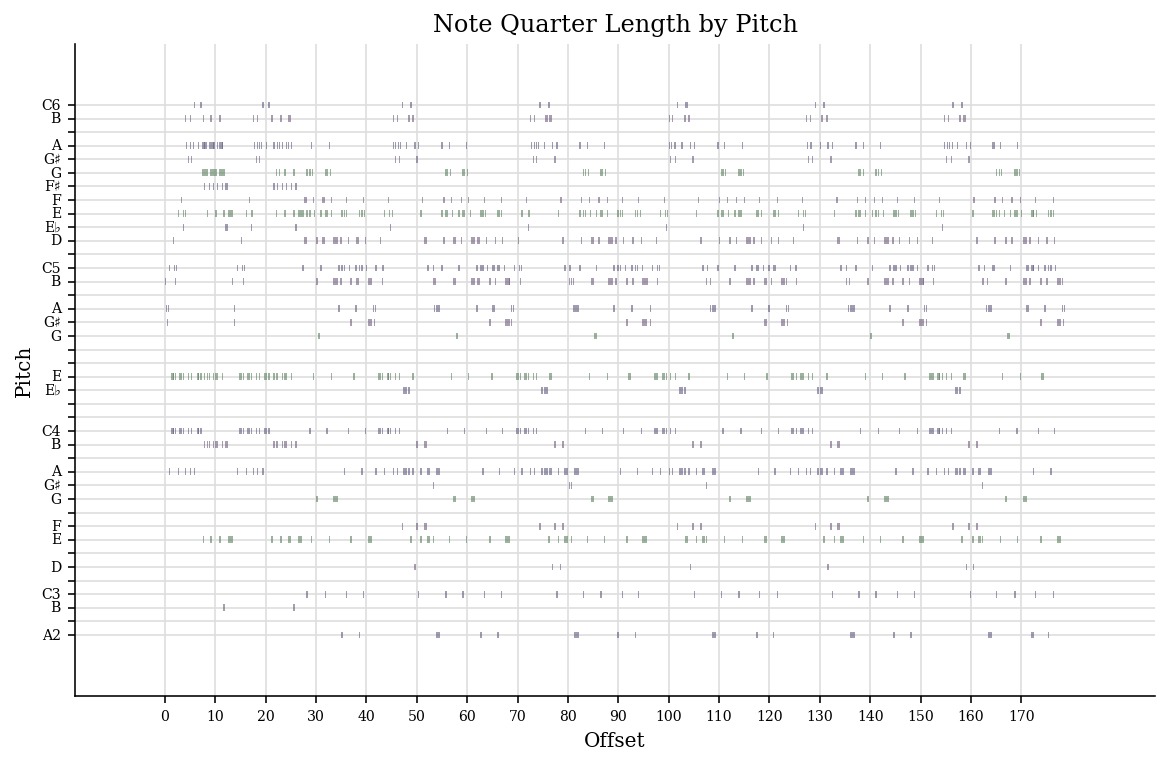

In [58]:
music = music21.converter.parse('output.mid')
music.plot()

In [59]:
Audio(play_music('output.mid'))